<a href="https://colab.research.google.com/github/acho110/Projects-Resume/blob/main/TSP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


- Alejandro Garcia
- Anika Filitz
- Kelly Yin

# Packages Used For Project

In [ ]:
import numpy as np
import math
import random
import gurobipy as gp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Data for Q1

In [ ]:
# This can be changed for purposes of file paths being different or different files
data = pd.read_csv('locations1.csv')

# Question 1 Clustering

In [ ]:
def assign_clusters(data, n_clusters):
    """This function assigns clusters to the data overall."""
    print("\nStarting clustering process...")
    np.random.seed(42) # setting randomness
    n_points = len(data) # points should be as long as the dataset it
    centroid_indices = np.random.choice(n_points, n_clusters, replace=False) # setting the indexes of the centroids to take in points and cluster counts desired
    centroids = data.iloc[centroid_indices][['x', 'y']].values # defining centroids with those vals from centroid_indices

    max_iters = 100
    for iter in range(max_iters):
        distances = np.zeros((n_points, n_clusters)) # empty zeros points to fill in
        for i in range(n_clusters): # the length being number of clusters we have
            distances[:, i] = np.sqrt((data['x'] - centroids[i, 0])**2 + (data['y'] - centroids[i, 1])**2) # doing the distance formula
        cluster_assignments = np.argmin(distances, axis=1) # returns the indices of the minimum values along an axis

        new_centroids = np.array([[data[cluster_assignments == i]['x'].mean(),
                                   data[cluster_assignments == i]['y'].mean()] for i in range(n_clusters)])

        if np.allclose(centroids, new_centroids):
            print(f"Clustering converged after {iter+1} iterations")
            break

        centroids = new_centroids # defining the current centroid as the new optimal one

    return cluster_assignments

def solve_tsp_for_cluster(cluster_points, dc_point):
    """This function is used for solving the TSP and takes in takes in the cluster points, with the distribution center."""
    # combine depot and cluster points, reset index
    points = pd.concat([dc_point, cluster_points]).reset_index(drop=True)
    N = len(points)
    print(f"Solving TSP for cluster with {N} points")


    distMat = np.zeros((N, N)) # create distance matrix between each pair of points
    for i in range(N):
        for j in range(N):
            distMat[i, j] = np.sqrt(
                (points.iloc[i]['x'] - points.iloc[j]['x'])**2 +
                (points.iloc[i]['y'] - points.iloc[j]['y'])**2
            )
    np.fill_diagonal(distMat, 1e17)  # set diagonal to large value to prevent self-loops, like in class where 0-0 of same location

    mod = gp.Model()
    x = mod.addMVar((N, N), vtype='B')
    u = mod.addMVar(N) # for the u constraint


    mod.setObjective(gp.quicksum(x[i, j] * distMat[i, j] for i in range(N) for j in range(N)), sense = gp.GRB.MINIMIZE) # minimize total travel distance

    # each city has one incoming and one outgoing path
    mod.addConstrs((gp.quicksum(x[i, j] for i in range(N)) == 1) for j in range(N))
    mod.addConstrs((gp.quicksum(x[i, j] for j in range(N)) == 1) for i in range(N))

    # for the u constraint
    mod.addConstrs((u[i] - u[j] + N * x[i, j] <= (N - 1)) for i in range(1, N) for j in range(1, N) if i != j) # from class written down


    mod.Params.OutputFlag = 0
    mod.Params.TimeLimit = 300
    mod.Params.MIPGap = 0.1

    print("Starting Gurobi optimization")
    mod.optimize()

    if mod.Status == gp.GRB.OPTIMAL:
        print("Optimal solution found!")
    elif mod.Status == gp.GRB.TIME_LIMIT:
        print(f"Time limit reached. Gap: {mod.MIPGap*100:.1f}%")

    return mod.objVal, x.X, points  # Return objective value, solution matrix, and points


def solve_multi_truck_tsp(data, n_trucks=10):
    """Running the TSP"""
    print(f"\n{'='*50}") # need to know how long the tsp is taking so time it with timestamp, AI helped
    print(f"Starting Multi-Truck TSP Solution at {pd.Timestamp.now().strftime('%H:%M:%S')}")
    print(f"{'='*50}")

    dc = pd.DataFrame({'x': [0], 'y': [0]}) # initialize distribution center coordinates
    print(f"Data loaded: {len(data)} delivery points")

    clusters = assign_clusters(data, n_trucks) # assign points to clusters based on the number of trucks
    print("Clustering completed!")

    total_distance = 0 # plot down total distance and empty list for routes to be appended into
    all_routes = []

    # solving the tsp
    for i in range(n_trucks):
        print(f"\n{'='*50}")
        print(f"CLUSTER {i+1}/{n_trucks}")
        print(f"Start Time: {pd.Timestamp.now().strftime('%H:%M:%S')}")

        # slice for current cluster
        cluster_data = data[clusters == i]
        print(f"Points in this cluster: {len(cluster_data)}")

        distance, route, points = solve_tsp_for_cluster(cluster_data, dc)
        total_distance += distance  # update total distance
        all_routes.append((route, points))  # save route and points for visualization

        # display the outouts
        print(f"\n✓ Cluster {i+1} COMPLETED")
        print(f"End Time: {pd.Timestamp.now().strftime('%H:%M:%S')}")
        print(f"Distance for this cluster: {distance:.2f}")
        print(f"Total distance so far: {total_distance:.2f}")
        print(f"{'='*50}")

    # plot routes and points for each cluster, AI helped
    plt.figure(figsize=(12, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, n_trucks))  # Color per truck

    for i, color in enumerate(colors):
        # scatter plot
        cluster_points = data[clusters == i]
        plt.scatter(cluster_points['x'], cluster_points['y'], c=[color], alpha=0.6, label=f'Truck {i+1}')

    # need the middle distribution center
    plt.scatter([0], [0], c='black', s=100, label='Distribution Center')

    # draw routes based on solution from each TSP
    for (route, points), color in zip(all_routes, colors):
        for i in range(len(route)):
            for j in range(len(route)):
                if route[i, j] > 0.5:
                    plt.plot([points.iloc[i]['x'], points.iloc[j]['x']],
                           [points.iloc[i]['y'], points.iloc[j]['y']],
                           c=color, alpha=0.3)

    plt.title('Multi-Truck TSP Solution')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print(f"\nAll clusters completed at {pd.Timestamp.now().strftime('%H:%M:%S')}")
    print(f"Final total distance: {total_distance:.2f}")

    return total_distance, all_routes  # Return total distance and all routes

#total_distance, routes = solve_multi_truck_tsp(data)


Starting Multi-Truck TSP Solution at 15:16:09
Data loaded: 500 delivery points

Starting clustering process...
Clustering converged after 16 iterations
Clustering completed!

CLUSTER 1/10
Start Time: 15:16:09
Points in this cluster: 52
Solving TSP for cluster with 53 points
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-27
Starting Gurobi optimization...
Optimal solution found!

✓ Cluster 1 COMPLETED
End Time: 15:17:13
Distance for this cluster: 6.34
Total distance so far: 6.34

CLUSTER 2/10
Start Time: 15:17:13
Points in this cluster: 68
Solving TSP for cluster with 69 points
Starting Gurobi optimization...
Optimal solution found!

✓ Cluster 2 COMPLETED
End Time: 15:17:37
Distance for this cluster: 7.46
Total distance so far: 13.79

CLUSTER 3/10
Start Time: 15:17:37
Points in this cluster: 63
Solving TSP for cluster with 64 points
Starting Gurobi optimization...
Optimal solution found!

✓ Cluster 3 COMPLETED
End Time: 15:18:07
Distance for thi

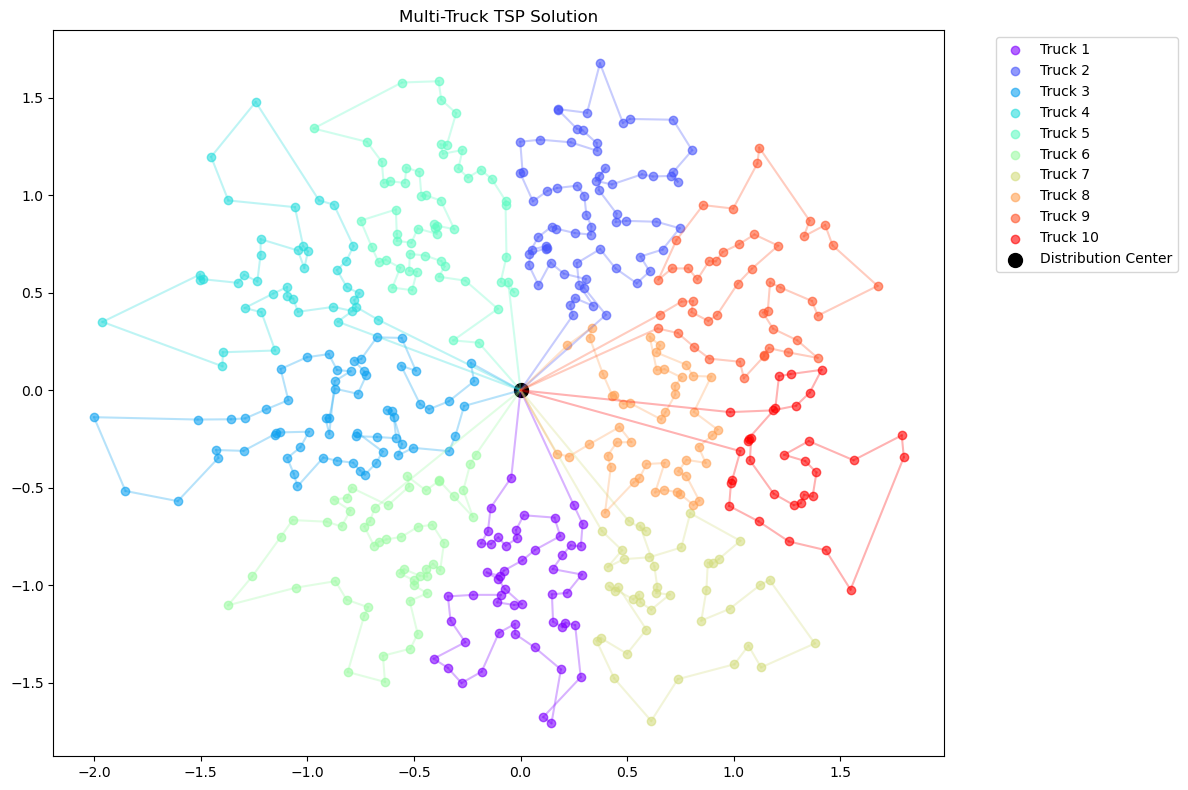


All clusters completed at 15:19:38
Final total distance: 68.18


In [ ]:
total_distance, routes = solve_multi_truck_tsp(data)

# Question 1, Simulation Annealing

In [ ]:
def total_squared_distance(routes, locs):
    """
    Calculate total squared distance for all routes.
    """
    total = 0
    for route in routes:
        route_dist = route_distance(route, locs)  # Calculate distances for each route
        total += sum(d**2 for d in route_dist)  # Square and sum distances
    return total

def route_distance(route, locs):
    """
    Calculate distances for a route, including distance from/to distribution center.
    """
    distances = []
    for i in range(len(route) - 1):
        start = locs.iloc[route[i]]
        end = locs.iloc[route[i+1]]
        dist = np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)  # Euclidean distance
        distances.append(dist)
    return distances

def initialize_routes(num_trucks, total_locations):
    """Create initial routes ensuring all locations are assigned."""
    locations = list(range(1, total_locations))  # List of locations (excluding depot)
    random.shuffle(locations)  # Shuffle locations for random initial routes

    base_locs_per_truck = len(locations) // num_trucks  # Locations per truck
    extra_locs = len(locations) % num_trucks  # Remaining locations

    routes = []
    current_pos = 0

    for i in range(num_trucks):
        truck_locs = base_locs_per_truck + (1 if i < extra_locs else 0)  # Assign extra if remainder
        route = [0] + locations[current_pos:current_pos + truck_locs] + [0]  # Start/end at depot
        routes.append(route)
        current_pos += truck_locs  # Update position for next truck

    return routes

def reverse_change(route):
    """Reverse a segment of the route, preserving depot visits."""
    if len(route) <= 3:
        return route  # Skip if only depot and one location
    i, j = sorted(random.sample(range(1, len(route)-1), 2))  # Select two indices
    return route[:i] + route[i:j+1][::-1] + route[j+1:]  # Reverse segment

def transport_change(route):
    """Move a segment of the route to another position, preserving depot visits."""
    if len(route) <= 3:
        return route
    i, j = sorted(random.sample(range(1, len(route)-1), 2))  # Select segment
    sub_path = route[i:j+1]
    new_route = route[:i] + route[j+1:]  # Remove segment
    insert_point = random.randint(1, len(new_route)-1)  # Choose insertion point
    return new_route[:insert_point] + sub_path + new_route[insert_point:]  # Insert segment

def reassign_change(routes):
    """Move locations between routes while preserving depot visits."""
    if len(routes) < 2:
        return routes

    from_truck = random.randint(0, len(routes)-1)
    to_truck = random.randint(0, len(routes)-1)

    while to_truck == from_truck:  # Ensure different trucks
        to_truck = random.randint(0, len(routes)-1)

    if len(routes[from_truck]) > 3:  # Must have at least one location
        package = random.choice(routes[from_truck][1:-1])  # Select non-depot location
        routes[from_truck].remove(package)  # Remove from source
        insert_point = random.randint(1, len(routes[to_truck])-1)  # Insertion point in destination
        routes[to_truck].insert(insert_point, package)  # Insert in destination

    return routes

def verify_coverage(routes, total_locations):
    """Verify that all locations are covered exactly once."""
    assigned_locs = set()
    for route in routes:
        assigned_locs.update(route[1:-1])  # Exclude depots

    expected_locs = set(range(1, total_locations))
    missing_locs = expected_locs - assigned_locs  # Locations not assigned
    extra_locs = assigned_locs - expected_locs  # Extra locations assigned

    # Display results
    print(f"\nRoute Coverage Analysis:")
    print(f"Total locations (excluding depot): {total_locations - 1}")
    print(f"Total locations assigned: {len(assigned_locs)}")
    print(f"Missing locations: {len(missing_locs)}")
    if missing_locs:
        print(f"Missing location IDs: {sorted(missing_locs)}")
    print(f"Extra locations: {len(extra_locs)}")
    if extra_locs:
        print(f"Extra location IDs: {sorted(extra_locs)}")

    return len(missing_locs) == 0 and len(extra_locs) == 0

def simulated_annealing(initial_routes, locs, num_iterations, initial_temp):
    """Optimize routes using simulated annealing."""
    current_routes = initial_routes
    current_cost = total_squared_distance(current_routes, locs)
    best_routes = current_routes.copy()
    best_cost = current_cost
    temp = initial_temp

    for i in range(num_iterations):
        change_type = random.choice(['reverse', 'transport', 'reassign'])

        if change_type in ['reverse', 'transport']:
            truck = random.randint(0, len(current_routes)-1)
            if change_type == 'reverse':
                new_route = reverse_change(current_routes[truck].copy())  # apply reverse
            else:
                new_route = transport_change(current_routes[truck].copy())
            new_routes = current_routes[:truck] + [new_route] + current_routes[truck+1:]
        else:
            new_routes = reassign_change([route.copy() for route in current_routes])

        new_cost = total_squared_distance(new_routes, locs)

        if new_cost < current_cost or random.random() < math.exp((current_cost - new_cost) / temp): # Accept new solution if better or by probability
            current_routes = new_routes
            current_cost = new_cost
            if current_cost < best_cost:  # Update best solution if improved
                best_routes = [route.copy() for route in current_routes]
                best_cost = current_cost

        temp *= 0.99

        # Progress update every 1000 iterations
        if i % 1000 == 0:
            print(f"Iteration {i}, Current Cost: {current_cost:.2f}, Best Cost: {best_cost:.2f}")

    return best_routes, best_cost

In [ ]:
def main():
    locs = pd.read_csv('/Users/Anika/Downloads/Fall 2024/BAX358/locations1.csv')

    # Add distribution center at (0, 0)
    dc_row = pd.DataFrame([[0, 0]], columns=locs.columns)
    locs_with_dc = pd.concat([dc_row, locs]).reset_index(drop=True)

    num_trucks = 10
    total_locations = locs_with_dc.shape[0]  # Total locations including depot

    initial_routes = initialize_routes(num_trucks, total_locations)

    print("\nInitial Routes Coverage:")
    verify_coverage(initial_routes, total_locations)

    # Run simulated annealing optimization
    best_routes, best_cost = simulated_annealing(
        initial_routes, locs_with_dc, num_iterations=100000, initial_temp=1000)

    print("\nFinal Routes Coverage:")
    verify_coverage(best_routes, total_locations)

    print(f"\nTotal squared distance using simulated annealing: {best_cost:.2f}")
    for i, route in enumerate(best_routes):
        print(f"Truck {i+1} route: {route}")

    return best_routes, best_cost, locs_with_dc

if __name__ == "__main__":
    best_routes, best_cost, locs_with_dc = main()


In [ ]:
def plot_routes(routes, locations):
    plt.figure(figsize=(12, 8), facecolor='white')
    # Set the axes background to white
    ax = plt.gca()
    ax.set_facecolor('white')

    colors = plt.cm.rainbow(np.linspace(0, 1, len(routes)))

    for i, (route, color) in enumerate(zip(routes, colors)):
        route_coords = locations.iloc[route]
        # Plot scatter points for each route
        plt.scatter(route_coords.iloc[:, 0], route_coords.iloc[:, 1],
                   c=[color], alpha=0.6, label=f'Route {i+1}')
        # Plot route lines
        plt.plot(route_coords.iloc[:, 0], route_coords.iloc[:, 1],
                c=color, alpha=0.3)

    plt.scatter([0], [0], c='black', s=100, label='Distribution Center')

    plt.title('Vehicle Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    print(f"\nAll clusters completed at {pd.Timestamp.now().strftime('%H:%M:%S')}")
    print(f"Final total distance: {best_cost:.2f}")

# Plot the results
plot_routes(best_routes, locs_with_dc)

# Question 2, Adding in Costs, Moving Forward with Simulation Annealing

In [ ]:
# Constants for cost and driver payment calculations
GASOLINE_COST_PER_MILE = 1    # Cost per mile for gasoline, labor, truck deprec.
DRIVER_PAYMENT = 300          # Base payment for each driver
OVERTIME_MULTIPLIER = 1.5     # Overtime pay multiplier
MILES_PER_HOUR = 60           # Assumed driving speed of 60 mi/hr
WORK_HOURS_PER_DAY = 8        # Assumed 8 hour workday

def calculate_total_cost(routes, locs):
    """Calculate total delivery cost including gasoline and driver payment."""
    num_drivers = len(routes)  # Number of drivers needed
    total_distance = sum(sum(route_distance(route, locs)) for route in routes)
    gasoline_cost = total_distance * GASOLINE_COST_PER_MILE
    driver_base_cost = num_drivers * DRIVER_PAYMENT
    return gasoline_cost + driver_base_cost  # Total cost

def calculate_overtime_cost(routes, locs):
    """Calculate total overtime cost incurred by drivers if necessary."""
    num_drivers = len(routes)
    if num_drivers <= 1:
        return 0  # no overtime if 1 or fewer drivers

    route_distances = [sum(route_distance(route, locs)) for route in routes]
    average_distance = sum(route_distances) / num_drivers
    overtime_cost = 0

    for distance in route_distances:
        if distance > average_distance * 1.1:  # if distance > 10% above average
            overtime_hours = (distance - average_distance) / MILES_PER_HOUR
            overtime_rate = (DRIVER_PAYMENT / WORK_HOURS_PER_DAY) * OVERTIME_MULTIPLIER
            overtime_cost += overtime_hours * overtime_rate

    return overtime_cost

def compute_total_delivery_cost(routes, locs):
    """Compute total delivery costs with all factors."""
    total_cost = calculate_total_cost(routes, locs)
    total_cost += calculate_overtime_cost(routes, locs)
    return total_cost

def optimize_for_trucks(num_trucks, locs, num_iterations, initial_temp):
    """Optimize routes for a given number of trucks."""
    initial_routes = initialize_routes(num_trucks, len(locs))  # initial truck routes
    best_routes, best_cost = simulated_annealing(initial_routes, locs, num_iterations, initial_temp)
    total_cost = compute_total_delivery_cost(best_routes, locs)
    return best_routes, total_cost

def main():
    locs = pd.read_csv('/Users/Anika/Downloads/Fall 2024/BAX358/locations1.csv')

    dc_row = pd.DataFrame([[0, 0]], columns=locs.columns)
    locs_with_dc = pd.concat([dc_row, locs]).reset_index(drop=True)  # Locations with distribution center

    results = []  # append results for each truck configuration here

    for num_trucks in range(1, 11):
        print(f"\nOptimizing for {num_trucks} truck(s)...")
        best_routes, total_cost = optimize_for_trucks(
            num_trucks, locs_with_dc, num_iterations=10000, initial_temp=1000)

        results.append((num_trucks, total_cost, best_routes))
        print(f"Total cost for {num_trucks} truck(s): ${total_cost:.2f}")

    optimal_trucks, optimal_cost, optimal_routes = min(results, key=lambda x: x[1]) # determine optimal number of trucks with minimum cost

    print(f"\nOptimal number of trucks: {optimal_trucks}")
    print(f"Optimal total cost: ${optimal_cost:.2f}")

    print("\nFinal Routes Coverage:")
    verify_coverage(optimal_routes, len(locs_with_dc))

    for i, route in enumerate(optimal_routes):
        print(f"Truck {i+1} route: {route}")

if __name__ == "__main__":
    main()


Optimizing for 1 truck(s)...
Iteration 0, Current Cost: 1237.99, Best Cost: 1237.99


KeyboardInterrupt: 

# Question 3, New Packages, New Locations
You want to have some sort of consistency in the
neighborhoods/routes that each truck travels to, so you’re thinking about putting packages that
need to be delivered close to yesterday on the same truck as yesterday, and then solving the
TSP for each truck.

- How much does this increase the total cost relative to completely starting over to solve the problem from scratch? Should you have consistency in the routes, or is worth it to start from scratch every day?
- Should there be some penalty/cost for drastically changing routes on drivers? Use either methodology from step 1, whichever worked best for you.

# Moving forward with the Simulation Annealing Approach

In [ ]:
def assign_to_historical_trucks(new_locs, prev_locs, prev_routes):
    """
    Assign new locations to trucks based on proximity to previous day's locations.

    Args:
        new_locs: DataFrame of new delivery locations
        prev_locs: DataFrame of previous day's locations
        prev_routes: List of routes from previous day

    Returns:
        initial_routes: List of routes for new locations
    """

    num_trucks = len(prev_routes)
    initial_routes = [[] for _ in range(num_trucks)] # initialize empty routes matching previous day truck count


    for route in initial_routes: # add depot (0) to start and end of each route
        route.append(0)

    for new_loc_idx in range(1, len(new_locs)):
        new_loc = new_locs.iloc[new_loc_idx]
        min_distance = float('inf')
        closest_prev_loc = None


        for prev_loc_idx in range(1, len(prev_locs)): # find closest location from previous day
            prev_loc = prev_locs.iloc[prev_loc_idx]
            dist = np.sqrt((new_loc[0] - prev_loc[0])**2 + (new_loc[1] - prev_loc[1])**2)

            if dist < min_distance:
                min_distance = dist
                closest_prev_loc = prev_loc_idx # updated the location to closest from previous


        assigned_truck = None # find which truck handled the closest location yesterday
        for truck_idx, route in enumerate(prev_routes):
            if closest_prev_loc in route:
                assigned_truck = truck_idx
                break


        if assigned_truck is None: # if no truck found (shouldn't happen), assign randomly
            assigned_truck = random.randint(0, num_trucks - 1)


        initial_routes[assigned_truck].insert(-1, new_loc_idx)  # add new location to assigned truck's route

    # Add final depot to all routes if not present
    for route in initial_routes:
        if route[-1] != 0:
            route.append(0)

    return initial_routes

def optimize_multi_day_routes(prev_locs, new_locs, prev_routes, num_iterations, initial_temp):
    """
    Optimize routes for new day while maintaining consistency with previous day.
    """

    dc_row = pd.DataFrame([[0, 0]], columns=new_locs.columns) # depot to the dataframe

    new_locs_with_dc = pd.concat([dc_row, new_locs]).reset_index(drop=True)

    initial_routes = assign_to_historical_trucks(new_locs_with_dc, prev_locs, prev_routes) # get that route based on whats happened already

    best_routes, best_cost = simulated_annealing(initial_routes, new_locs_with_dc, num_iterations, initial_temp)

    total_cost = compute_total_delivery_cost(best_routes, new_locs_with_dc)

    return best_routes, total_cost

def main():
    prev_locs = pd.read_csv('/Users/Anika/Downloads/Fall 2024/BAX358/locations1.csv')
    new_locs = pd.read_csv('/Users/Anika/Downloads/Fall 2024/BAX358/locations2.csv')

    dc_row = pd.DataFrame([[0, 0]], columns=prev_locs.columns)
    prev_locs_with_dc = pd.concat([dc_row, prev_locs]).reset_index(drop=True)

    new_locs_with_dc = pd.concat([dc_row, new_locs]).reset_index(drop=True)

# settting for 2 trucks
    print("Optimizing previous day's routes")
    prev_best_routes, prev_cost = optimize_for_trucks(2, prev_locs_with_dc, num_iterations=10000, initial_temp=1000)

    print(f"\nPrevious day's total cost: ${prev_cost:.2f}")
    print("\nPrevious day's routes:")
    for i, route in enumerate(prev_best_routes):
        # updating index as loop goes on
        print(f"Truck {i+1} route: {route}")


    print("\nOptimizing new day's routes with consistency") # same but now with a consistent route
    new_best_routes, new_cost = optimize_multi_day_routes(prev_locs_with_dc, new_locs, prev_best_routes, num_iterations=10000,
                                                          initial_temp=1000)

    print(f"\nNew day's total cost: ${new_cost:.2f}")
    print("\nNew day's routes:")
    for i, route in enumerate(new_best_routes):
        print(f"Truck {i+1} route: {route}")

    print("\nFinal Routes Coverage:")
    verify_coverage(new_best_routes, len(new_locs) + 1)  # +1 for depot

    return (prev_best_routes, prev_locs_with_dc, prev_cost,
            new_best_routes, new_locs_with_dc, new_cost)

if __name__ == "__main__":
    prev_best_routes, prev_locs_with_dc, prev_cost, new_best_routes, new_locs_with_dc, new_cost = main()

Optimizing previous day's routes...
Iteration 0, Current Cost: 1222.51, Best Cost: 1222.51
Iteration 1000, Current Cost: 817.62, Best Cost: 817.62
Iteration 2000, Current Cost: 504.19, Best Cost: 504.19
Iteration 3000, Current Cost: 371.24, Best Cost: 371.24
Iteration 4000, Current Cost: 288.84, Best Cost: 288.84
Iteration 5000, Current Cost: 236.91, Best Cost: 236.91
Iteration 6000, Current Cost: 204.95, Best Cost: 204.95
Iteration 7000, Current Cost: 183.50, Best Cost: 183.50
Iteration 8000, Current Cost: 169.00, Best Cost: 169.00
Iteration 9000, Current Cost: 158.24, Best Cost: 158.24

Previous day's total cost: $842.71

Previous day's routes:
Truck 1 route: [0, 208, 331, 265, 189, 68, 219, 273, 379, 358, 355, 364, 309, 360, 325, 423, 442, 376, 415, 421, 440, 391, 483, 396, 434, 381, 345, 462, 276, 306, 289, 388, 419, 402, 407, 493, 17, 74, 117, 193, 186, 101, 168, 140, 133, 51, 52, 181, 182, 170, 112, 93, 134, 89, 3, 23, 50, 109, 104, 116, 167, 235, 300, 227, 248, 223, 204, 184, 15

# Running our original code with the new data set completely from the start

In [ ]:
def main():
    locs = pd.read_csv('/Users/Anika/Downloads/Fall 2024/BAX358/locations2.csv')

    dc_row = pd.DataFrame([[0, 0]], columns=locs.columns)
    locs_with_dc = pd.concat([dc_row, locs]).reset_index(drop=True)  # locations with distribution center of 0,0

    results = []  # append results for each truck configuration here

    for num_trucks in range(2, 3):
        print(f"\nOptimizing for {num_trucks} truck(s)...")
        best_routes, total_cost = optimize_for_trucks(
            num_trucks, locs_with_dc, num_iterations = 10000, initial_temp = 1000)

        results.append((num_trucks, total_cost, best_routes))
        print(f"Total cost for {num_trucks} truck(s): ${total_cost:.2f}")

    optimal_trucks, optimal_cost, optimal_routes = min(results, key=lambda x: x[1]) # determine optimal number of trucks with minimum cost

    print(f"\nOptimal number of trucks: {optimal_trucks}")
    print(f"Optimal total cost: ${optimal_cost:.2f}")

    print("\nFinal Routes Coverage:")
    verify_coverage(optimal_routes, len(locs_with_dc))

    for i, route in enumerate(optimal_routes):
        print(f"Truck {i+1} route: {route}")

if __name__ == "__main__":
    main()


Optimizing for 2 truck(s)...
Iteration 0, Current Cost: 1231.95, Best Cost: 1231.95
Iteration 1000, Current Cost: 736.81, Best Cost: 736.81
Iteration 2000, Current Cost: 475.46, Best Cost: 475.46
Iteration 3000, Current Cost: 355.71, Best Cost: 355.71
Iteration 4000, Current Cost: 288.49, Best Cost: 288.49
Iteration 5000, Current Cost: 234.56, Best Cost: 234.56
Iteration 6000, Current Cost: 202.75, Best Cost: 202.75
Iteration 7000, Current Cost: 170.72, Best Cost: 170.72
Iteration 8000, Current Cost: 151.98, Best Cost: 151.98
Iteration 9000, Current Cost: 143.78, Best Cost: 143.78
Total cost for 2 truck(s): $829.66

Optimal number of trucks: 2
Optimal total cost: $829.66

Final Routes Coverage:

Route Coverage Analysis:
Total locations (excluding depot): 500
Total locations assigned: 500
Missing locations: 0
Extra locations: 0
Truck 1 route: [0, 225, 383, 281, 296, 350, 318, 400, 305, 265, 341, 327, 376, 428, 371, 365, 427, 392, 444, 63, 14, 406, 474, 403, 395, 320, 374, 373, 356, 405

TypeError: cannot unpack non-iterable NoneType object

NameError: name 'optimal_routes' is not defined